# Stage 1: Data Cleaning, Preprocessing and exploratory data analysis including topic modelling

Stage 1: Data cleaning, preprocessing, and exploratory data analysis including topic modelling

In this step, students get a first overview of the dataset and learn to prepare it for the subsequent NLP analyses. This could involve the following tasks:

- Data Collection and Cleaning
     - Acquire a comprehensive dataset of cleantech texts.
     - Perform data cleaning to remove irrelevant information, special characters, and duplicates.
- Text Preprocessing
    - Tokenize the text data into words or phrases.
    - Apply stemming or lemmatization to reduce words to their root form.
    - Remove stop words and non-informative terms.
    - Convert text to lowercase for consistency.
    - Exploratory Data Analysis (EDA)
    - Compute basic statistics such as word counts, document lengths, and term frequencies.
    - Create word clouds to visualize the most frequent terms.
    - Plot histograms or bar charts to analyze the distribution of major cleantech topics and categories.
    - Identify outliers or anomalies in the data.
    - Visualize the distribution of texts with scatter plots or other suitable visualization techniques.
- Topic Modeling
    - Test topic modeling techniques such as LDA and NMF
    (https://github.com/AnushaMeka/NLP-Topic-Modeling-LDA-NMF), Top2Vec
    (https://github.com/ddangelov/Top2Vec) and BERTopic
    (https://github.com/MaartenGr/BERTopic).
    - Visualize and interpret the discovered topics using techniques like word clouds or topic proportion distribution plots.
    - Evaluate the quality of the topics.
    - Refine the topic model based on evaluation results and domain expertise.

Outputs:
- Notebook with data cleaning and preprocessing steps.
- EDA notebook with visualizations on e.g., hidden topics.

## Import Libraries

In [1]:
!python -m spacy download en_core_web_sm

import numpy as np
import pandas as pd
import nltk
import spacy
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from string import punctuation
import re

nlp = spacy.load('en_core_web_sm')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 16.6 MB/s eta 0:00:0000:0100:01

[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [2]:
# Download nltk packages
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/nina/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/nina/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/nina/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## Load the Data

First step is to load data from the csv file into a dataframe.

In [3]:
df = pd.read_csv("/Users/nina/Downloads/cleantech_media_dataset_v1_20231109.csv")

In [4]:
# Inspect dataframe
pd.DataFrame.head(df)

Unnamed: 0                                              title        date  \
0        1280  Qatar to Slash Emissions as LNG Expansion Adva...  2021-01-13   
1        1281               India Launches Its First 700 MW PHWR  2021-01-15   
2        1283              New Chapter for US-China Energy Trade  2021-01-20   
3        1284  Japan: Slow Restarts Cast Doubt on 2030 Energy...  2021-01-22   
4        1285     NYC Pension Funds to Divest Fossil Fuel Shares  2021-01-25   

  author                                            content       domain  \
0    NaN  ["Qatar Petroleum ( QP) is targeting aggressiv...  energyintel   
1    NaN  ["• Nuclear Power Corp. of India Ltd. ( NPCIL)...  energyintel   
2    NaN  ["New US President Joe Biden took office this ...  energyintel   
3    NaN  ["The slow pace of Japanese reactor restarts c...  energyintel   
4    NaN  ["Two of New York City's largest pension funds...  energyintel   

                                                 url  
0  https://www.energyintel.com/0000017b-a7dc-de4c...  
1  https://www.energyintel.com/0000017b-a7dc-de4c...  
2  https://www.energyintel.com/0000017b-a7dc-de4c...  
3  https://www.energyintel.com/0000017b-a7dc-de4c...  
4  https://www.energyintel.com/0000017b-a7dc-de4c...

The article contents are contained in the 'content' column. This will be the main target for the topic modelling. The author column appears to contain mainly NaNs.

In [5]:
# Inspect dataframe shape
df.shape

(9607, 7)

The dataframe contains 9607 records and 7 attributes.

In [6]:
# Check for NAs
print(df.isnull().sum())

Unnamed: 0       0
title            0
date             0
author        9576
content          0
domain           0
url              0
dtype: int64


There are no NAs in the title or content columns which are the most important for topic modelling.

### Preprocessing

We create a function to apply the first preprocessing steps. This includes dropping any duplicated records, changing the contents to lower case, removing non alpha-numeric characters, tokenizing the contents and adding a word count.

In [7]:
def preprocess_data(df):
    # Remove duplicates
    df = df.drop_duplicates()
    
    # Convert content to lower case
    df['content_cleaned'] = df['content'].apply(lambda x: x.lower())
    
    # Remove symbols and punctuation (not sure about this step)
    df['content_cleaned'] = df['content_cleaned'].apply(lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x))
    
    # Tokenize
    df['tokenized_content'] = df['content_cleaned'].apply(lambda x: nltk.word_tokenize(x))
    
    # Add word count column
    df['word_count'] = df['tokenized_content'].apply(lambda x: len(x))
    
    # Remove unused columns
    df.drop('Unnamed: 0', axis=1, inplace=True)
    df.drop('author', axis=1, inplace=True)

    return df

df = preprocess_data(df)

In [8]:
df[['content_cleaned', 'tokenized_content', 'word_count']].head()

content_cleaned  \
0  qatar petroleum  qp is targeting aggressive cu...   
1   nuclear power corp of india ltd  npcil synchr...   
2  new us president joe biden took office this we...   
3  the slow pace of japanese reactor restarts con...   
4  two of new york citys largest pension funds sa...   

                                   tokenized_content  word_count  
0  [qatar, petroleum, qp, is, targeting, aggressi...         442  
1  [nuclear, power, corp, of, india, ltd, npcil, ...         538  
2  [new, us, president, joe, biden, took, office,...         706  
3  [the, slow, pace, of, japanese, reactor, resta...         687  
4  [two, of, new, york, citys, largest, pension, ...         394

Next we can lemmatize words and remove stop words. In the next step we compare two lemmatizers: nltk and spaCy.

In [9]:
# Create lemmatizer
lemmatizer = nltk.WordNetLemmatizer()
nltk_lemma = df['tokenized_content'].apply(lambda x:
                    [lemmatizer.lemmatize(word) for word in x])

nltk_lemma

0       [qatar, petroleum, qp, is, targeting, aggressi...
1       [nuclear, power, corp, of, india, ltd, npcil, ...
2       [new, u, president, joe, biden, took, office, ...
3       [the, slow, pace, of, japanese, reactor, resta...
4       [two, of, new, york, city, largest, pension, f...
                              ...                        
9602    [stratum, clean, energy, ha, closed, a, 300, m...
9603    [global, renewable, energy, developer, rsted, ...
9604    [veolia, north, america, a, provider, of, envi...
9605    [once, the, selfproclaimed, leading, renewable...
9606    [arevon, energy, inc, ha, closed, financing, o...
Name: tokenized_content, Length: 9607, dtype: object

Here we can see that the nltk lemmatizer has removed the -s from "us" (line 2) and "has" (line 9606). It also hasn't successfully lemmatized words such as "closed", "leading" etc. This could cause problems when do the topic modelling. Next we see if the spaCy lemmatizer has the same problems.

In [ ]:
# Apply spacy lemmatizer
spacy_lemma = df['tokenized_content'].apply(lambda x:
                    [token.lemma_ for token in nlp(" ".join(x))])

In [10]:
spacy_lemma = df['tokenized_content'].apply(lambda x:
                    [token.lemma_ for token in nlp(" ".join(x))])
spacy_lemma

0       [qatar, petroleum, qp, be, target, aggressive,...
1       [nuclear, power, corp, of, india, ltd, npcil, ...
2       [new, us, president, joe, biden, take, office,...
3       [the, slow, pace, of, japanese, reactor, resta...
4       [two, of, new, york, city, large, pension, fun...
                              ...                        
9602    [strata, clean, energy, have, close, a, 300, m...
9603    [global, renewable, energy, developer, rste, b...
9604    [veolia, north, america, a, provider, of, envi...
9605    [once, the, selfproclaime, lead, renewable, po...
9606    [arevon, energy, inc, have, close, financing, ...
Name: tokenized_content, Length: 9607, dtype: object

The spaCy lemmatizer seems to have done a better job. So we will use this for our processing.

In [11]:
df['lemmatized_content'] = spacy_lemma

Now we can remove stops. Below we test three different stop word lists.

In [12]:
# Remove stops
stop_words_nltk = set(nltk.corpus.stopwords.words("english"))
stops_nltk = df['lemmatized_content'].apply(lambda x:
                    [token for token in x if token not in stop_words_nltk])

stop_words_spacy = nlp.Defaults.stop_words
stops_spacy = df['lemmatized_content'].apply(lambda x: [word for word in x if word.lower() not in stop_words_spacy])

from gensim.parsing.preprocessing import STOPWORDS

stop_words_gensim = STOPWORDS
stops_gensim = df['lemmatized_content'].apply(lambda x: [word for word in x if word.lower() not in stop_words_gensim])

print(len(stops_gensim[0]))
print(len(stops_nltk[0]))
print(len(stops_spacy[0]))

259
279
259


Spacy and Gensim seem to have removed the same number of words. We can choose one of them as for our pre-processing.

In [13]:
df['stops_spacy'] = stops_spacy
df.head()

title        date  \
0  Qatar to Slash Emissions as LNG Expansion Adva...  2021-01-13   
1               India Launches Its First 700 MW PHWR  2021-01-15   
2              New Chapter for US-China Energy Trade  2021-01-20   
3  Japan: Slow Restarts Cast Doubt on 2030 Energy...  2021-01-22   
4     NYC Pension Funds to Divest Fossil Fuel Shares  2021-01-25   

                                             content       domain  \
0  ["Qatar Petroleum ( QP) is targeting aggressiv...  energyintel   
1  ["• Nuclear Power Corp. of India Ltd. ( NPCIL)...  energyintel   
2  ["New US President Joe Biden took office this ...  energyintel   
3  ["The slow pace of Japanese reactor restarts c...  energyintel   
4  ["Two of New York City's largest pension funds...  energyintel   

                                                 url  \
0  https://www.energyintel.com/0000017b-a7dc-de4c...   
1  https://www.energyintel.com/0000017b-a7dc-de4c...   
2  https://www.energyintel.com/0000017b-a7dc-de4c...   
3  https://www.energyintel.com/0000017b-a7dc-de4c...   
4  https://www.energyintel.com/0000017b-a7dc-de4c...   

                                     content_cleaned  \
0  qatar petroleum  qp is targeting aggressive cu...   
1   nuclear power corp of india ltd  npcil synchr...   
2  new us president joe biden took office this we...   
3  the slow pace of japanese reactor restarts con...   
4  two of new york citys largest pension funds sa...   

                                   tokenized_content  word_count  \
0  [qatar, petroleum, qp, is, targeting, aggressi...         442   
1  [nuclear, power, corp, of, india, ltd, npcil, ...         538   
2  [new, us, president, joe, biden, took, office,...         706   
3  [the, slow, pace, of, japanese, reactor, resta...         687   
4  [two, of, new, york, citys, largest, pension, ...         394   

                                  lemmatized_content  \
0  [qatar, petroleum, qp, be, target, aggressive,...   
1  [nuclear, power, corp, of, india, ltd, npcil, ...   
2  [new, us, president, joe, biden, take, office,...   
3  [the, slow, pace, of, japanese, reactor, resta...   
4  [two, of, new, york, city, large, pension, fun...   

                                         stops_spacy  
0  [qatar, petroleum, qp, target, aggressive, cut...  
1  [nuclear, power, corp, india, ltd, npcil, sync...  
2  [new, president, joe, biden, office, week, usc...  
3  [slow, pace, japanese, reactor, restart, conti...  
4  [new, york, city, large, pension, fund, divest...

Now we can make a wordcloud to get an idea of the most frequent terms in the entire corpus.

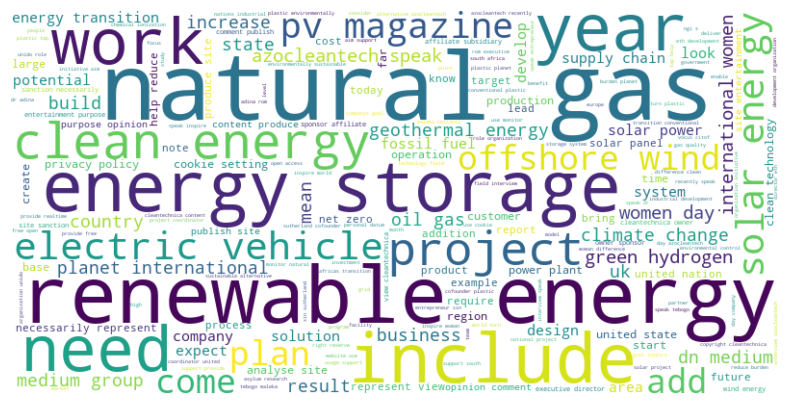

In [14]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Join text for each doc
df['final_cleaned'] = df['stops_spacy'].apply(lambda x: ' '.join(x))

# Join all text
all_tokens_string = ' '.join(df['stops_spacy'].explode())

# Create wordcloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_tokens_string)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

From this wordcloud we can already see some potential topics. For example: natural gas, energy storage, offshore wind, electric vehicles, and solar energy. We can also see that the pre-processing has not cleaned out all redundant bits of information. For example "cookie setting" and "privacy policy" may need to be cleaned out of the corpus. This level of cleanliness may be enough to extract the main topics, however.

### Exploratory Analysis

First we can look at term frequencies. We can use nltk.probability.FreqDist to calculate the frequencies of terms in each document.

In [15]:
# Calculate term frequencies for each record
df['term_frequencies'] = df['stops_spacy'].apply(lambda x:
                        nltk.probability.FreqDist(x))

df['term_frequencies'].head()

0    {'qatar': 3, 'petroleum': 1, 'qp': 6, 'target'...
1    {'nuclear': 4, 'power': 4, 'corp': 1, 'india':...
2    {'new': 1, 'president': 1, 'joe': 1, 'biden': ...
3    {'slow': 1, 'pace': 1, 'japanese': 1, 'reactor...
4    {'new': 7, 'york': 7, 'city': 6, 'large': 1, '...
Name: term_frequencies, dtype: object

Then we can get the most frequent term for each document, and the number of documents that have the same most frequent word. The histogram below shows that a large number of documents have energy as the most frequent word, followed by solar, gas, hydrogen and geothermal. We can surmise that these technologies are the main topics of a large number of articles.

We also see that "s" is the most frequent term in a large number of documents. It may therefore be useful to go back and remove this in a further cleaning step.

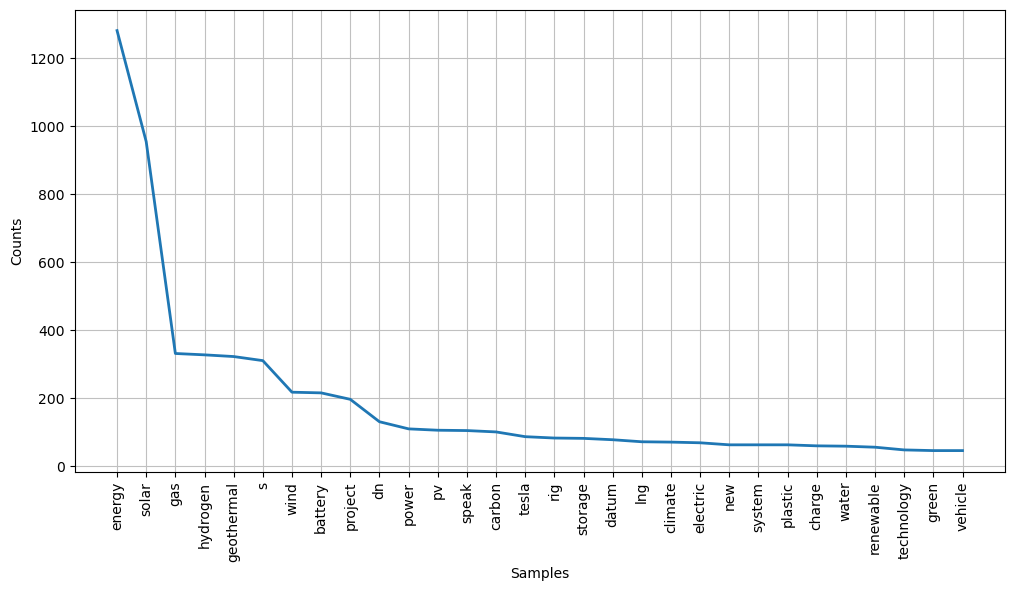

In [17]:
# Aggregate most frequent words across all documents
freq_words = [max(term, key=term.get) for term in df['term_frequencies']]
corpus_freq_dist = nltk.probability.FreqDist(freq_words)

# Plot histogram
plt.figure(figsize=(12, 6))
corpus_freq_dist.plot(30, cumulative=False)
plt.show()

In [18]:
freq_words

['million',
 'project',
 'china',
 'reactor',
 'new',
 'court',
 'energy',
 'china',
 'water',
 'power',
 'nuclear',
 'exelon',
 'saf',
 'co2',
 'lng',
 'plan',
 'saf',
 'energy',
 'gunvor',
 'energy',
 'nuclear',
 'oil',
 'exxon',
 'energy',
 'wind',
 'energy',
 'carbon',
 'capture',
 'emission',
 'hydrogen',
 'hydrogen',
 'cost',
 'shell',
 'repsol',
 'offset',
 'nuclear',
 'company',
 'chevron',
 'nuclear',
 'gw',
 'nuclear',
 'project',
 'carbonneutral',
 'renewable',
 'return',
 'power',
 'bp',
 'duke',
 'billion',
 'shale',
 'hydrogen',
 'shipping',
 'hydrogen',
 'nuclear',
 'bd',
 'transborder',
 'energy',
 'reactor',
 'climate',
 'pertamina',
 'lng',
 'lng',
 'share',
 'nuclear',
 'carbon',
 'lng',
 'state',
 'lng',
 'phillip',
 'ecopetrol',
 'padmanathan',
 'biden',
 'green',
 'bd',
 'chevron',
 'battery',
 'fusion',
 'china',
 'water',
 'schlumberger',
 'gazprom',
 'production',
 'renewable',
 'ccs',
 'hydrogen',
 'climate',
 'russia',
 'repsol',
 'hydrogen',
 'hydrogen',
 'l

In [19]:
from pathlib import Path
from textblob import TextBlob

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 6.0)
import plotly.graph_objs as go

import plotly.graph_objs as go
from plotly.offline import iplot
from IPython.core.interactiveshell import InteractiveShell

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

pd.options.display.max_colwidth = 100
pd.options.display.max_columns = 30

We can also take a closer look at the word frequencies by each "domain". First we can see how many articles come from each domain.

In [20]:
df['domain'].value_counts()

cleantechnica            1861
azocleantech             1627
pv-magazine              1215
energyvoice              1020
solarindustrymag          673
naturalgasintel           659
thinkgeoenergy            646
rechargenews              559
solarpowerworldonline     505
energyintel               234
pv-tech                   232
businessgreen             158
greenprophet               80
ecofriend                  38
solarpowerportal.co        34
eurosolar                  28
decarbxpo                  19
solarquarter               17
indorenergy                 2
Name: domain, dtype: int64

Next we can compare the first document from each of the top 3 domains.

In [21]:
# Compare three domains
cleantechnica = df[df['domain'] == 'cleantechnica']['final_cleaned']
azocleantech = df[df['domain'] == 'azocleantech']['final_cleaned']
pv_magazine = df[df['domain'] == 'pv-magazine']['final_cleaned']
print(f"pv_magazine: {pv_magazine[:1]}\nazocleantech: {azocleantech[:1]}\ncleantechnica: {cleantechnica[:1]}")

pv_magazine: 6948    pv magazine webinar discuss paul wormser cea elias hinckley k l gate irs safe harbor provision s...
Name: final_cleaned, dtype: object
azocleantech: 2629    click allow agree storing cookie device enhance site navigation analyse site usage support provi...
Name: final_cleaned, dtype: object
cleantechnica: 1284    installment threepart series community solar low moderateincome costumer piece focus partnership...
Name: final_cleaned, dtype: object


This is not too illuminating so we will instead go on to create a word cloud from all the documents in each of the top 3 domains.

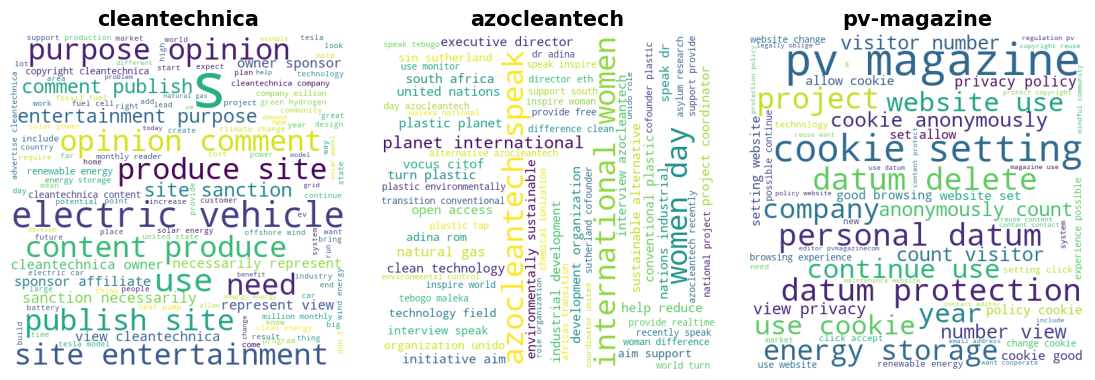

In [22]:
rows=1
cols=3

row=0
col=0
titles = ['cleantechnica', 'azocleantech', 'pv-magazine']
w = [cleantechnica.str.cat(),azocleantech.str.cat(),pv_magazine.str.cat(),]
fig, ax = plt.subplots(1, 3, figsize=(12.5,6.5))

for i in range(3):
  ax[col].imshow(WordCloud(width = 500, height = 500,
                background_color ='white',
                min_font_size = 10).generate(w[i]))
  ax[col].axis("off")
  ax[col].set_title(titles[i], fontdict={'fontsize': 15, 'fontweight' : 'bold'})
  row=row+1
  if row==rows:
     row=0
     col=col+1

plt.subplots_adjust(left=0.07, right=0.93, wspace=0.1, hspace=0.0,top=0.94,bottom=0.09)
plt.show()

We can extrapolate from these word clouds that cleantechnica has many articles about electric vehicles. While azocleantech mentions international women's day and plastic many times. PV-magazine clearly has a data protection pop-up on its website because the most common words are about data and cookies. It may be helpful to expand our stop-word list to help filter out these words in another processing step.

We can also see that energy storage is a frequent word in PV-magazine.


With the new information we have we can expand the stop words list and go through the previous steps to generate new word clouds.

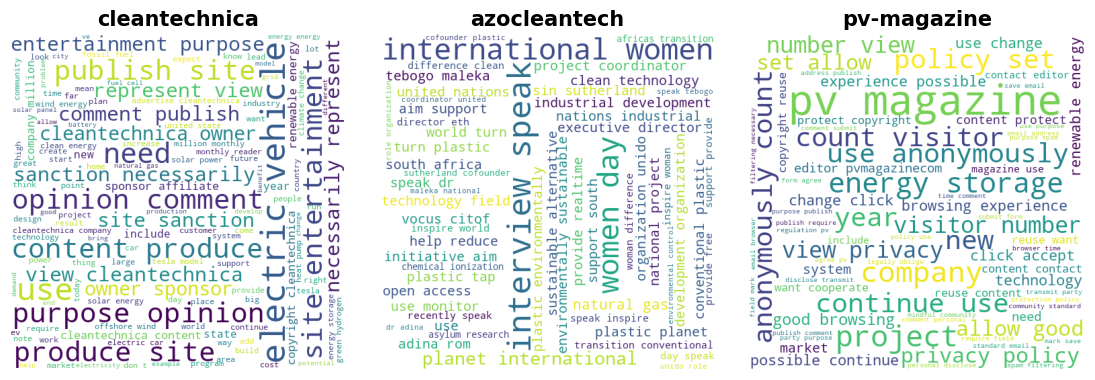

In [23]:
stop_words_spacy = set(stop_words_spacy)
additional_stop_words = ["s", "cookie", "setting", "datum", "website", "azocleantech"]

stop_words_spacy.update(additional_stop_words)

def stop_removal(df):
    stops_spacy = df['lemmatized_content'].apply(lambda x: [word for word in x if word.lower() not in stop_words_spacy])
    
    df['stops_spacy'] = stops_spacy
    
    df['final_cleaned'] = df['stops_spacy'].apply(lambda x: ' '.join(x))

    return df

df = stop_removal(df)

all_tokens_string = ' '.join(df['stops_spacy'].explode())

cleantechnica = df[df['domain'] == 'cleantechnica']['final_cleaned']
azocleantech = df[df['domain'] == 'azocleantech']['final_cleaned']
pv_magazine = df[df['domain'] == 'pv-magazine']['final_cleaned']

rows=1
cols=3

row=0
col=0
titles = ['cleantechnica', 'azocleantech', 'pv-magazine']
w = [cleantechnica.str.cat(),azocleantech.str.cat(),pv_magazine.str.cat(),]
fig, ax = plt.subplots(1, 3, figsize=(12.5,6.5))

for i in range(3):
  ax[col].imshow(WordCloud(width = 500, height = 500,
                background_color ='white',
                min_font_size = 10).generate(w[i]))
  ax[col].axis("off")
  ax[col].set_title(titles[i], fontdict={'fontsize': 15, 'fontweight' : 'bold'})
  row=row+1
  if row==rows:
     row=0
     col=col+1

plt.subplots_adjust(left=0.07, right=0.93, wspace=0.1, hspace=0.0,top=0.94,bottom=0.09)
plt.show()


### Type Token Ratio 

As part of the exploratory data analysis, we can calcualte the Type Token Ratio for each document. To do so we create a function that divide the number of unique tokens by the total number of tokens.

In [25]:
# Calculate TTR
def calculate_ttr(tokens):
    unique_tokens = set(tokens)
    ttr = len(unique_tokens) / len(tokens)
    
    return ttr

df['ttr'] = df['stops_spacy'].apply(calculate_ttr)

In [27]:
print(df[['ttr']])

           ttr
0     0.621622
1     0.722930
2     0.635678
3     0.682864
4     0.662338
...        ...
9602  0.771574
9603  0.700461
9604  0.720000
9605  0.541763
9606  0.748879

[9607 rows x 1 columns]


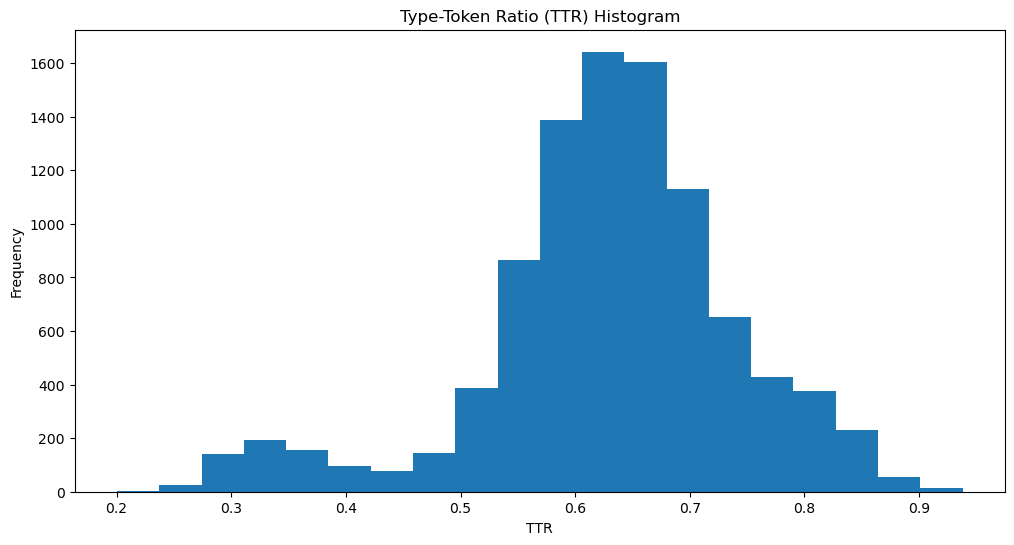

In [28]:
plt.figure(figsize=(12, 6))
plt.hist(df['ttr'], bins=20)  # You can adjust the number of bins as needed
plt.title('Type-Token Ratio (TTR) Histogram')
plt.xlabel('TTR')
plt.ylabel('Frequency')
plt.show()

Most documents have a TTR around 0.6-0.7, this indicates the documents are in general not very lexically diverse. There is another smaller group of documents that have a much higher lexical diversity at around 0.3 TTR.

In [29]:
# Add 'content length'
#df['content Length'] = df['content'].astype(str).apply(len)

# We already have content length, it is the word count column

df['num_tokens'] = df['stops_spacy'].apply(lambda x: len(x))

# Add polarity
df['polarity'] = df['content_cleaned'].map(lambda text: TextBlob(str(text)).sentiment.polarity)

In [30]:
# Descriptive statistics of your dataframe
df.describe()

word_count          ttr   num_tokens     polarity
count  9607.000000  9607.000000  9607.000000  9607.000000
mean    761.734152     0.629396   424.993546     0.124826
std     448.680542     0.112366   240.868089     0.061608
min     193.000000     0.200397    87.000000    -0.247789
25%     424.000000     0.578630   242.000000     0.084147
50%     648.000000     0.636542   367.000000     0.120312
75%     980.000000     0.694133   546.000000     0.161567
max    2984.000000     0.937888  1747.000000     0.466667

In [31]:
# Take a look at our new features
df.iloc[0][['num_tokens', 'polarity']]

num_tokens         259
polarity      0.067613
Name: 0, dtype: object

We also applied a simple sentiment analysis to the articles to roughly determine whether they are mainly positive or negative. The plot below shows the distribution of sentiment polarity. A positive number indicates a mainly positive sentiment, while a negative number indicates a more negative sentiment.

Text(0.5, 1.0, 'Polarity distribution')

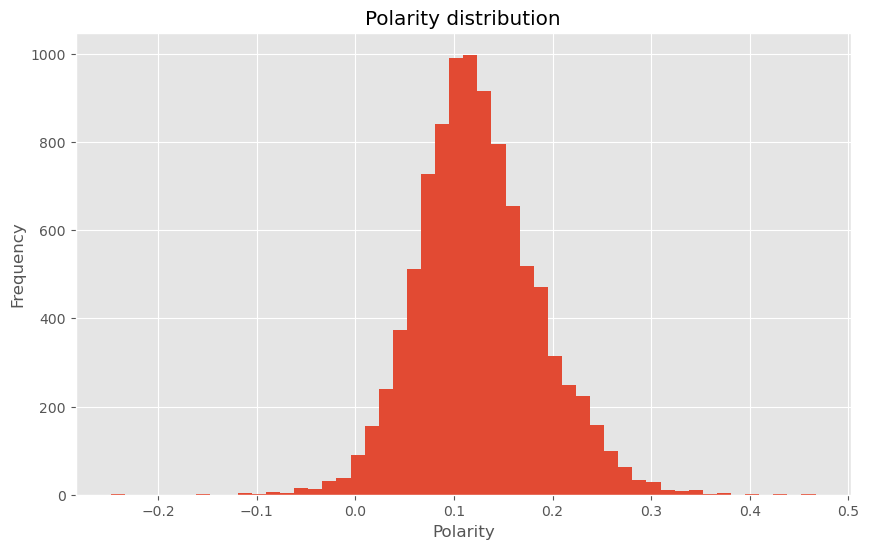

In [33]:
# Plot the distribution of polarity sentiment score
# change plotting colors per client request
plt.style.use('ggplot')
df['polarity'].plot(kind='hist', bins=50)
plt.xlabel('Polarity')
plt.title('Polarity distribution')

We can see that in general the articles are fairly neutral, which is typical of mor objective/scientific text.

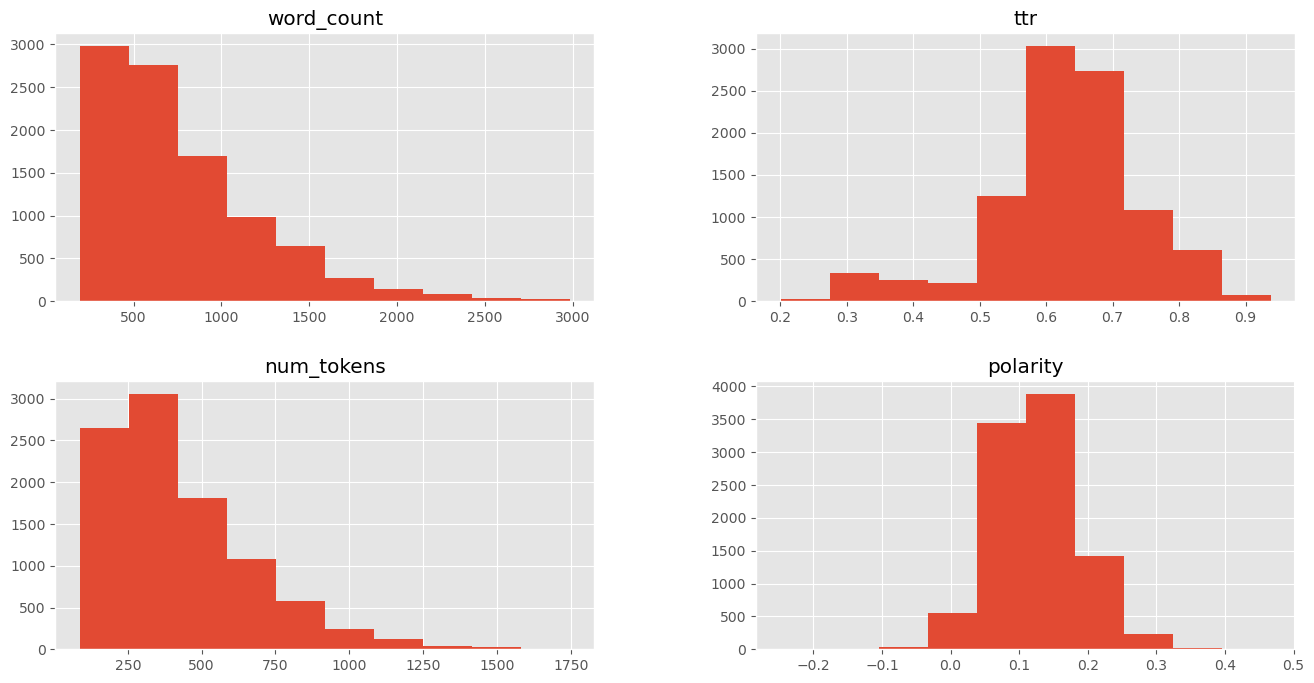

In [34]:
df.hist(figsize=(16,8));

## BERTopic Modelling

In [35]:
contents = df["content"]
titles = df["title"]

In [36]:
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance, PartOfSpeech
from bertopic import BERTopic

2023-11-27 01:14:56.649902: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [53]:
# Pre-calculate embeddings
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(contents, show_progress_bar=True)

Batches:   0%|          | 0/301 [00:00<?, ?it/s]

In [78]:
#Umap model
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', random_state=42)

#hdbscan model
hdbscan_model = HDBSCAN(min_cluster_size=35, metric='euclidean', cluster_selection_method='eom', prediction_data=True)

#vectorizer model
vectorizer_model = CountVectorizer(stop_words=stop_words_spacy, min_df=2, ngram_range=(1, 2))

# KeyBERT
keybert_model = KeyBERTInspired()

# Part-of-Speech
pos_model = PartOfSpeech("en_core_web_sm")

# MMR
mmr_model = MaximalMarginalRelevance(diversity=0.3)

# All representation models
representation_model = {
    "KeyBERT": keybert_model,
    "MMR": mmr_model,
    "POS": pos_model
}

In [100]:
topic_model = BERTopic(

  # Pipeline models
  embedding_model=embedding_model,
  umap_model=umap_model,
  hdbscan_model=hdbscan_model,
  vectorizer_model=vectorizer_model,
  representation_model=representation_model,

  # Hyperparameters
  top_n_words=10,
  verbose=True
)

topics, probs = topic_model.fit_transform(contents, embeddings)

2023-11-27 02:38:35,230 - BERTopic - Reduced dimensionality
2023-11-27 02:38:35,672 - BERTopic - Clustered reduced embeddings


In [101]:
topic_model.get_topic_info()

Topic  Count                                        Name  \
0      -1   3750                   -1_energy_solar_power_new   
1       0    681  0_geothermal_geothermal energy_energy_heat   
2       1    608                1_tesla_electric_charging_ev   
3       2    425        2_hydrogen_green_green hydrogen_fuel   
4       3    378               3_gas_lng_natural gas_natural   
5       4    338             4_women_spoke_plastic_interview   
6       5    336    5_climate_change_research_climate change   
7       6    245             6_battery_batteries_lithium_ion   
8       7    244                   7_solar_energy_project_mw   
9       8    223             8_solar_manufacturing_pv_supply   
10      9    211                    9_solar_pv_energy_africa   
11     10    181                 10_cell_pv_perovskite_solar   
12     11    145            11_dn media_dn_media group_media   
13     12    140         12_plastic_plastics_waste_recycling   
14     13    139                13_net zero_zero_net_climate   
15     14    135            14_storage_battery_system_energy   
16     15    126     15_wind_offshore_offshore wind_scotland   
17     16    124      16_cleantechnica_energy_published_wind   
18     17    107               17_climate_energy_clean_biden   
19     18     91             18_carbon_co2_capture_emissions   
20     19     87                  19_share_units_plugin_bevs   
21     20     86    20_storage_energy_energy storage_battery   
22     21     84                        21_rigs_rig_week_gas   
23     22     71         22_wind_offshore_offshore wind_boem   
24     23     67                23_bcf_gas_cents_natural gas   
25     24     66                  24_north sea_sea_north_oil   
26     25     61                    25_green_eco_home_people   
27     26     61                26_eu_european_energy_europe   
28     27     59      27_australia_energy_australian_project   
29     28     56                 28_india_solar_indian_power   
30     29     55                  29_wind_solar_power_energy   
31     30     51     30_wind_offshore_offshore wind_floating   
32     31     50        31_bike_bikes_cleantechnica_electric   
33     32     44             32_biomass_research_spoke_women   
34     33     43           33_mexico_gas_natural gas_natural   
35     34     39  34_solar_california_metering_rooftop solar   

                                                                                         Representation  \
0                                 [energy, solar, power, new, storage, pv, said, wind, renewable, data]   
1   [geothermal, geothermal energy, energy, heat, project, drilling, heating, development, power, ge...   
2       [tesla, electric, charging, ev, vehicle, cleantechnica, vehicles, car, electric vehicle, model]   
3                [hydrogen, green, green hydrogen, fuel, energy, gas, production, ammonia, carbon, use]   
4                                   [gas, lng, natural gas, natural, said, ngi, daily, oil, news, year]   
5   [women, spoke, plastic, interview, planet, women day, international women, planet international,...   
6                 [climate, change, research, climate change, women, spoke, carbon, food, water, study]   
7   [battery, batteries, lithium, ion, lithium ion, ion batteries, electric, energy, storage, materi...   
8   [solar, energy, project, mw, projects, community, renewable, power, renewable energy, community ...   
9                  [solar, manufacturing, pv, supply, capacity, domestic, energy, industry, gw, module]   
10                     [solar, pv, energy, africa, data, power, mw, magazine, pv magazine, electricity]   
11            [cell, pv, perovskite, solar, cells, efficiency, modules, data, solar cells, pv magazine]   
12                    [dn media, dn, media group, media, group, recharge, read, privacy, data, read dn]   
13        [plastic, plastics, waste, recycling, packaging, materials, spoke, women, chemical, research]   
14                     [net ze

In [81]:
representative_docs = topic_model.get_representative_docs(topic=0)
representative_docs[0][:500]

'["The Western Governors \' Association has published recommendations to accelerate deployment of geothermal technologies in the Western U.S.", \'As part of the bipartisan Heat Beneath Our Feet initiative, the Western Governors’ Association ( WGA) has published a comprehensive report detailing the group’ s recommendations and strategies to accelerate the deployment of geothermal technologies across the Western U.S. states. The full report can be viewed here. The Heat Beneath Our Feet initiative was'

In [82]:
topic_model.get_topic(0, full=True)

{'Main': [('geothermal', 0.07598731077861631),
  ('geothermal energy', 0.02774886131768765),
  ('energy', 0.025369835112229552),
  ('heat', 0.014848405882533312),
  ('project', 0.013734389354090472),
  ('drilling', 0.013052007194851023),
  ('heating', 0.012874448011670871),
  ('development', 0.012550185193011413),
  ('power', 0.01185003264639047),
  ('geothermal power', 0.009758447952675357)],
 'KeyBERT': [('geothermal energy', 0.7841434),
  ('geothermal resources', 0.7777415),
  ('geothermal development', 0.76860654),
  ('geothermal projects', 0.757878),
  ('geothermal power', 0.7552707),
  ('geothermal', 0.7422526),
  ('geothermal project', 0.7355925),
  ('geothermal heating', 0.72884685),
  ('geothermal systems', 0.6934819),
  ('deep geothermal', 0.6299157)],
 'MMR': [('geothermal', 0.07598731077861631),
  ('geothermal energy', 0.02774886131768765),
  ('energy', 0.025369835112229552),
  ('heat', 0.014848405882533312),
  ('project', 0.013734389354090472),
  ('drilling', 0.01305200719

In [83]:
topic_distr, _ = topic_model.approximate_distribution(contents, window=8, stride=4)

100%|███████████████████████████████████████████| 10/10 [00:39<00:00,  3.91s/it]


In [84]:
content_id = 10
print(contents[content_id][:500])

["Taiwan Power Co. ( Taipower) is retiring its 985 megawatt Kuosheng-1 boiling water reactor six months early, in June, because its spent fuel pool has run out of room. The closure will occur with the utility and the plant's host municipality, New Taipei City, at loggerheads over the state-run utility's plans to build a dry cask storage facility at the site. “ We have no choice but to retire this unit earlier since there is no more space in its spent fuel pool, ” Economics Affairs Minister Wang 


In [85]:
topic_model.visualize_distribution(topic_distr[content_id])

In [88]:
# Reduce outliers
new_topics = topic_model.reduce_outliers(contents, topics)

# Reduce outliers with pre-calculate embeddings instead
new_topics = topic_model.reduce_outliers(contents, topics, strategy="embeddings", embeddings=embeddings)

100%|█████████████████████████████████████████████| 4/4 [00:38<00:00,  9.72s/it]


In [93]:
#topic_model.update_topics(contents, topics=new_topics)

In [102]:
topic_model.visualize_topics()

In [104]:
topic_model.visualize_hierarchy(custom_labels=True)

In [105]:
reduced_embeddings = UMAP(n_neighbors=10, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)

In [108]:
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, custom_labels=True)

In [109]:
topic_model.visualize_documents(titles, reduced_embeddings=reduced_embeddings, custom_labels=True, hide_annotations=True)